# Disclaimer

This is my attempt to test the effectiveness of Progressive Resizing, TTA and Mixup for Image Classification.

[Github](https://github.com/Melisa-Surja/Practical-Deep-Learning-For-Coders/tree/main/05-07) folder for this project.

Course source from [Ch 7. Training a State-of-the-Art Model](https://github.com/fastai/fastbook/blob/master/07_sizing_and_tta.ipynb).

Dataset from [Lance Zhang](https://www.kaggle.com/lantian773030/pokemonclassification).

~ Melisa Surja 

# Installing Dependencies

In [4]:
# !pip install -Uqq fastbook
# !pip install kaggle
import fastbook
fastbook.setup_book()

In [5]:
from fastbook import *
from fastai.callback.fp16 import *

# Downloading Dataset

We're going to use [Pokemon Dataset from Kaggle](https://www.kaggle.com/lantian773030/pokemonclassification).

You need an API key to use the Kaggle API. 

How to get one: 
1. Register an account from Kaggle
1. Click on your profile picture on the Kaggle website, and choose Account
1. Click Create New API Token. This will save a file called `kaggle.json` to your PC. 
1. Put the `kaggle.json` file in `~/root/.kaggle/` folder

In [6]:
from kaggle import api
path = Path('Pokemon')
Path.BASE_PATH = path
path

Path('.')

Pro-tip: use the command `api.dataset_list(search='pokemon')` to get the dataset's reference name, `lantian773030/pokemonclassification`.

In [4]:
if not path.exists():
  path.mkdir(parents=true)
  api.dataset_download_files('lantian773030/pokemonclassification', path=path, unzip=true)
path.ls()

(#1) [Path('PokemonData')]

# Prepare Dataset

The dataset contains `.svg` and other image file types that might cause errors, so let's limit our image files to `.jpg` and `.jpeg` files only.

I'm also not applying Normalization because we're not using a pre-trained model.

### Data Augmentation

I'm adding `mult=1.5` to amplify batch transformation effects. Don't pick a number that's too big because it might distort your images too much.

In [7]:
def get_dls(bs, size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=partial(get_files, extensions=['.jpg','.jpeg']),
                   get_y=parent_label,
                   splitter=RandomSplitter(seed=42),
                   item_tfms=Resize(460),
                   batch_tfms=[*aug_transforms(size=size, min_scale=0.75, mult=1.5), 
                               Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(path/'PokemonData', bs=bs, num_workers=0) #num_workers=0 for windows.

Tried `bs=512`, the model was less accurate overall and didn't improve training speedd at all.

Size 32 or 64 didn't reduce learning time at all, they're all around 1:03

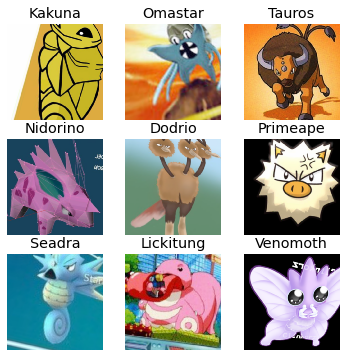

In [9]:
dls = get_dls(64, 96)
dls.train.show_batch(figsize=(6,6))

Let's view our data augmentation results. If the transformation results are too extreme, it can be reduced by reducing `mult` variable from DataBlock API.

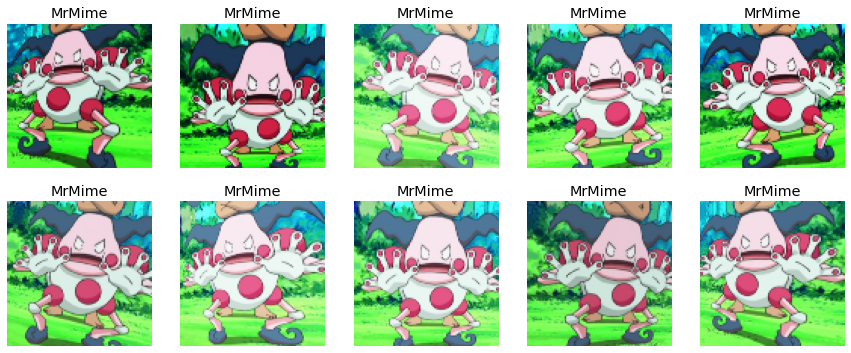

In [24]:
dls.train.show_batch(max_n=10, nrows=2, unique=True)

# Start Training Model

Not using `loss_func=CrossEntropyLossFlat()` because the accuracy is lower somehow?

In [45]:
learn = Learner(dls, xresnet152(n_out=dls.c), metrics=accuracy).to_fp16()

(0.05248074531555176, 0.43651583790779114)

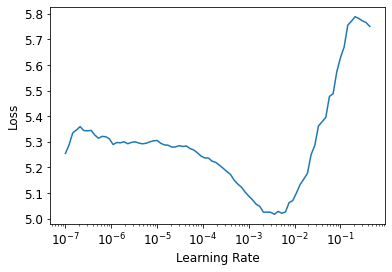

In [43]:
lr_min,lr_steep = learn.lr_find()
lr_min,lr_steep

In [46]:
learn.fit_one_cycle(10, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.280869,4.130296,0.114264,01:18
1,3.876203,4.702787,0.105302,01:19
2,3.372243,3.326472,0.202390,01:20
3,2.687400,2.695168,0.323376,01:20
4,2.188360,2.182176,0.421957,01:20
5,1.762807,1.783878,0.532487,01:20
6,1.275650,1.386950,0.635549,01:20
7,0.968333,1.192333,0.691561,01:20
8,0.722489,1.035828,0.718447,01:20
9,0.585089,0.999632,0.727409,01:20


# Using MixUp

Let's make a second learner that uses MixUp to train.

Pay attention that the learning rate for non-mixup and with-mixup learner are similar. MixUp takes 2-3 seconds longer to train.

In [47]:
learn2 = Learner(dls, xresnet152(n_out=dls.c), metrics=accuracy, cbs=MixUp()).to_fp16()

(0.07585775852203369, 0.6309573650360107)

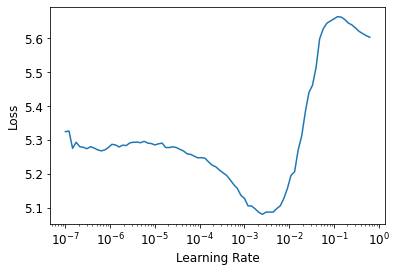

In [48]:
lr_min2,lr_steep2 = learn2.lr_find()
lr_min2,lr_steep2

In [49]:
learn2.fit_one_cycle(10, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.439505,4.355733,0.076923,01:20
1,4.298513,4.613818,0.084391,01:20
2,3.805876,3.724484,0.162808,01:20
3,3.262786,3.419400,0.224795,01:20
4,2.827098,2.494491,0.375653,01:20
5,2.365754,1.920001,0.463779,01:20
6,1.946644,1.567828,0.586258,01:20
7,1.669619,1.292255,0.652726,01:20
8,1.409796,1.105889,0.699776,01:20
9,1.250272,1.078448,0.711725,01:20


Mixup's improvement only starts showing after epoch #15. 

In the end, after 20 epochs mixup is about 1.4% more accurate.

# Using Pretrained Model

In [77]:
learn3 = cnn_learner(dls, resnet50, metrics=accuracy)

(0.006918309628963471, 0.005248074419796467)

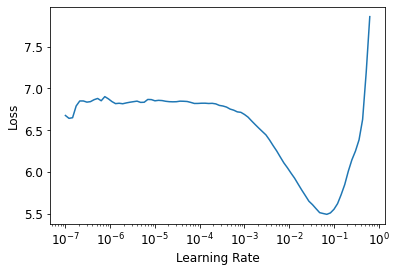

In [71]:
lr_min3,lr_steep3 = learn3.lr_find()
lr_min3,lr_steep3

In [78]:
learn3.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,3.176970,2.013995,0.533981,01:02
1,2.144147,1.645859,0.613144,01:03
2,1.347104,0.934577,0.767737,01:03
3,0.845376,0.563441,0.852128,01:01
4,0.532377,0.522001,0.857356,01:01


It's quite obvious that pretrained model outperforms all untrained models, even with basic options.

## Deepest model

I'm going to try using `resnet152` to find out its accuracy.

In [15]:
learn4 = cnn_learner(dls, resnet152, metrics=accuracy)

(0.004786301031708717, 0.007585775572806597)

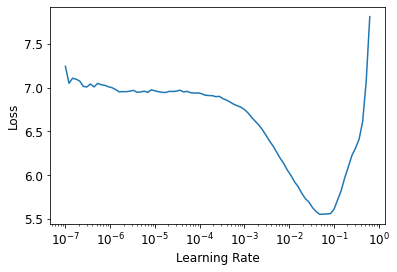

In [73]:
lr_min4,lr_steep4 = learn4.lr_find()
lr_min4,lr_steep4

In [16]:
learn4.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.901583,3.896984,0.393577,01:18
1,2.208215,2.090652,0.538462,01:19
2,1.388338,0.896799,0.761016,01:17
3,0.794020,0.559285,0.849888,01:17
4,0.482764,0.483693,0.864824,01:18


`resnet152` is about 10 seconds longer to train per epoch than `resnet50`.

# Fine tuning with bigger images

Let's use the most accurate learner of all 3: `learn3`, the pretrained model.

- Bigger images `size=224` with `bs=16` take about 02:03 = 123 seconds to train for one epoch with `resnet50`. With `resnet152`, they take 03:40 = 220 seconds.
- Smaller images `size=96` with `bs=64` take about 01:03 = 63 seconds to train for one epoch with `resnet50`. With `resnet152`, they take 01:18 = 78 seconds.

In [17]:
best_learner = learn4
best_learner.dls = get_dls(16, 224)

(0.0015848932787775993, 0.005248074419796467)

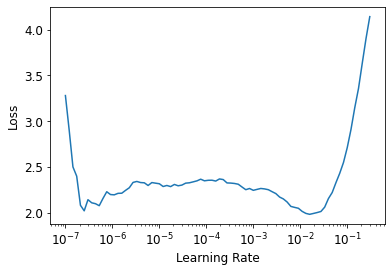

In [13]:
lr_min_final,lr_steep_final = best_learner.lr_find()
lr_min_final,lr_steep_final

In [18]:
best_learner.fine_tune(6, 5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.266667,0.736913,0.808813,02:49


epoch,train_loss,valid_loss,accuracy,time
0,1.236475,1.162775,0.696789,03:40
1,1.332549,0.945552,0.734130,03:40
2,0.847121,0.628114,0.817028,03:40
3,0.449327,0.307728,0.913368,03:40
4,0.246765,0.245969,0.942494,03:40
5,0.141183,0.225940,0.946229,03:40


# Using TTA

TTA improves accuracy by about ~1.2% percent.

In [19]:
preds,targs = best_learner.tta()
accuracy(preds, targs).item()

0.9522031545639038

# Let's test our model!

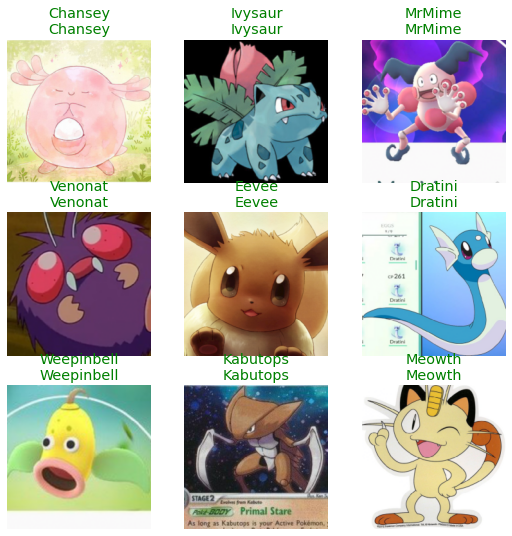

In [20]:
best_learner.show_results()

Let's see our most faulty predictions!

In [21]:
interp = ClassificationInterpretation.from_learner(best_learner)
interp.most_confused(min_val=3)

[('Kingler', 'Krabby', 4),
 ('Kadabra', 'Alakazam', 3),
 ('Marowak', 'Cubone', 3)]

Very interesting! The confusions come from pokemons from the same evolution line.
Most people who don't know pokemons would probably think that they are the same pokemons as well, so our model has done well!

# Exporting the model

In [22]:
export_file_name = 'PokemonClassifier.pkl'
best_learner.export(fname=export_file_name)

# Error: CUDA out of memory

If you get this error, free up your memory by deleting unused variables.

In [101]:
import torch
import gc
# del variable_names learn,learn2,learn3,dls
gc.collect()
torch.cuda.empty_cache()

If it still doesn't work, shut down all kernels and restart the notebook.

# Load learner

`load_learner` requires all your custom code be in the exact same place as when exporting your Learner (the main script, or the module you imported it from).

In [31]:
loaded_learner = load_learner(export_file_name)

In [32]:
loaded_learner.predict((path/'PokemonData/Arcanine').ls()[0])

('Arcanine',
 tensor(5),
 tensor([1.1416e-09, 1.4899e-11, 2.9600e-10, 6.2974e-10, 1.8583e-11, 9.9994e-01, 2.8097e-09, 4.0880e-09, 4.1278e-11, 7.8820e-11, 6.0099e-11, 3.6282e-10, 1.0828e-12, 1.0576e-09, 7.0809e-12, 3.7614e-11,
         4.3621e-11, 8.7929e-10, 2.6667e-10, 3.8661e-13, 2.2115e-09, 4.0043e-11, 1.7923e-11, 1.3119e-12, 1.6269e-09, 5.8650e-10, 7.3814e-13, 6.6024e-11, 9.9968e-12, 2.2237e-10, 5.9734e-11, 1.4578e-07,
         1.0543e-11, 5.7806e-09, 1.0866e-10, 4.7796e-11, 1.0996e-08, 3.2639e-09, 1.5528e-09, 1.0658e-08, 7.1589e-10, 5.7710e-10, 1.9678e-10, 3.9210e-12, 2.2573e-12, 4.4090e-12, 3.4871e-10, 2.1042e-09,
         3.2809e-09, 1.6518e-13, 5.4509e-06, 6.8992e-09, 2.7701e-10, 9.8648e-07, 1.7927e-08, 7.0608e-11, 1.5952e-09, 6.4456e-09, 4.2052e-13, 5.7940e-07, 9.6956e-10, 2.3185e-10, 1.5349e-09, 4.5532e-11,
         4.7481e-10, 1.9330e-08, 6.4207e-12, 2.4230e-12, 1.2850e-12, 1.2802e-12, 2.7411e-10, 2.2177e-10, 3.3042e-08, 7.0837e-09, 8.5987e-13, 3.7347e-09, 2.9590e-13, 1.3269